In [5]:
import numpy as np
import matplotlib.pyplot as plt
import smote_variants as sv
import imbalanced_databases as imbd
import pandas as pd

from collections import Counter

from sklearn import datasets

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
class synthsonic(sv.OverSampling) :
    
    def __init__(self,
                 proportion=1.0,
                 distinct_threshold=-1,
                 n_jobs=1, 
                 random_state=None) :
        
        
        super().__init__()
        
        self.check_greater_or_equal(proportion, "proportion", 0)
        self.check_n_jobs(n_jobs, 'n_jobs')

        self.proportion = proportion
        self.distinct_threshold = distinct_threshold
        self.n_jobs = n_jobs

        self.set_random_state(random_state)
        
    @classmethod
    def parameter_combinations(cls, raw=False) :
        
        parameter_combinations = {'proportion': [0.1, 0.25, 0.5, 0.75,
                                                 1.0, 1.5, 2.0]}
        
        return cls.generate_parameter_combinations(parameter_combinations, raw)
    
    def sample(self, X, y) :
        
        # Find minority class
        # self.find_minority(X,y)
        
        self.class_label_statistics(X, y)
        
        self.X_min = X[y == self.min_label]
        
        # determine n_samples
        self.n_to_sample = self.det_n_to_sample(self.proportion,
                                           self.class_stats[self.maj_label],
                                           self.class_stats[self.min_label])
        
        # fit model
        kde = KDECopulaNNPdf(distinct_threshold=self.distinct_threshold)
        kde = kde.fit(self.X_min)
        
        
        # sample
        x1 = kde.sample_no_weights(n_samples=self.n_to_sample)
        
        X_samp = np.vstack([X,x1])
        y_samp = np.hstack([y, [self.min_label]*self.n_to_sample])
        
        return X_samp, y_samp

#     def get_params(self) :
#         return {'proportion': self.proportion, 
#                 'n_jobs': self.n_jobs,
#                 'distinct_threshold':self.distinct.threshold,
#                 'random_state': self.random_state}
    


def writetodict(dataset,name) :
    
    data = dataset.iloc[:,:-1].values
    target = dataset.iloc[:,-1].values

    return {'data':data,
            'target':target,
            'name':name}
    
def plotter(X,y,title) :
    
    counter = Counter(y)
    
    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        plt.scatter(X[rowix, 0], X[rowix, 1], label=str(label))
    plt.legend()
    plt.title(title)
    plt.show()

    print(counter)

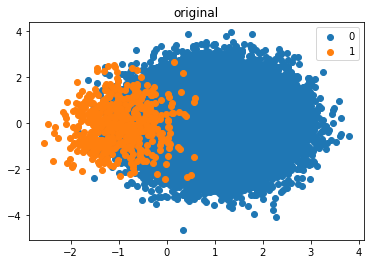

Counter({0: 49500, 1: 500})


In [7]:
X, y = datasets.make_classification(n_samples=50000, n_features = 4, n_redundant=0, 
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=7)

counter = Counter(y)


plotter(X,y,"original")

In [27]:
synth = synthsonic()
xs, ys = synth.sample(X,y)

Building tree: 100%|██████████| 3/3.0 [00:00<00:00, 2139.59it/s]
Generating for node: 3: 100%|██████████| 4/4 [00:00<00:00,  9.22it/s]


In [29]:
xs.shape

(99000, 4)

99000